In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('/Users/ccit0915/Desktop/交通部航港局AI智慧專案/進出港船舶合併.xlsx')

In [7]:
import pandas as pd

# 移除「臺灣港」欄位（皆為台中港，無區辨力）
df.drop(columns=['臺灣港'], inplace=True)

# 將進港資料的目的港、目的洲，出港資料的來源港、來源洲設為 NaN（結構性缺失）
df.loc[df['進出'] == 'Inbound', ['目的港', '目的洲']] = pd.NA
df.loc[df['進出'] == 'Outbound', ['來源港', '來源洲']] = pd.NA

# 頻率編碼函數（保留 NaN）
def frequency_encode(series):
    freq = series.value_counts(normalize=True)
    return series.map(freq)

# 對四個欄位進行頻率編碼
for col in ['目的洲', '目的港', '來源洲', '來源港']:
    df[f'{col}_freq'] = frequency_encode(df[col])
df

,目的洲,目的港,來源洲,來源港,艘次,船舶種類,年月,進出,目的洲_freq,目的港_freq,來源洲_freq,來源港_freq
0,<NA>,<NA>,大洋洲,開普福類特瑞港(AUCQP),2,雜貨船,2020/05,Inbound,NaN,NaN,0.038006,0.006182
1,<NA>,<NA>,大洋洲,紐卡斯爾港(AUNTL),7,散裝船,2020/05,Inbound,NaN,NaN,0.038006,0.005792
2,<NA>,<NA>,南美洲,科羅內爾(CLCNL),2,雜貨船,2020/05,Inbound,NaN,NaN,0.006248,0.001302
3,<NA>,<NA>,亞洲,北海港(CNBHY),1,雜貨船,2020/05,Inbound,NaN,NaN,0.925029,0.002408
4,<NA>,<NA>,亞洲,防城港(CNFAN),1,散裝船,2020/05,Inbound,NaN,NaN,0.925029,0.002473
...,...,...,...,...,...,...,...,...,...,...,...,...
30638,亞洲,臺北港(TWTPE),<NA>,<NA>,1,工作船,2025/04,Outbound,0.948092,0.035151,NaN,NaN
30639,亞洲,TWTXGOS,<NA>,<NA>,5,挖泥船,2025/04,Outbound,0.948092,0.033056,NaN,NaN
30640,亞洲,TWTXGOS,<NA>,<NA>,2,受泥船,2025/04,Outbound,0.948092,0.033056,NaN,NaN
30641,亞洲,TWTXGOS,<NA>,<NA>,3,電纜敷設船,2025/04,Outbound,0.948092,0.033056,NaN,NaN


In [9]:
group_cols = ['年月', '船舶種類', '進出']
df_monthly = df.groupby(group_cols)['艘次'].sum().reset_index()

In [15]:
# 將 '年月' 欄位轉為 datetime 格式
df_monthly['年月'] = pd.to_datetime(df_monthly['年月'])
df['年月'] = pd.to_datetime(df['年月'])  # 應該是 df，而不是尚未建立的 df_ports

# 建立一個新欄位 '港口'，根據進出方向選擇來源港或目的港
df['港口'] = df.apply(lambda row: row['來源港'] if row['進出'] == 'Inbound' else row['目的港'], axis=1)

# groupby 三個欄位並計算港口數量（nunique）
df_ports = df.groupby(['年月', '船舶種類', '進出'])['港口'].nunique().reset_index()
df_ports = df_ports.rename(columns={'港口': '航線組合數'})

# 合併兩張表格
df_final = pd.merge(df_monthly, df_ports, on=['年月', '船舶種類', '進出'], how='left')

In [17]:
df_final

,年月,船舶種類,進出,艘次,航線組合數
0,2020-05-01,LNG,Inbound,11,5
1,2020-05-01,LNG,Outbound,10,5
2,2020-05-01,LPG,Inbound,6,6
3,2020-05-01,LPG,Outbound,6,6
4,2020-05-01,佈管線船,Inbound,1,1
...,...,...,...,...,...
3268,2025-04-01,錨船,Outbound,3,2
3269,2025-04-01,雜貨船,Inbound,76,40
3270,2025-04-01,雜貨船,Outbound,84,44
3271,2025-04-01,電纜敷設船,Inbound,10,6


In [184]:
# 第一種方式（根據進出方向選港口）
df['港口_依進出'] = df.apply(lambda row: row['來源港'] if row['進出'] == 'Inbound' else row['目的港'], axis=1)
港口_依進出 = df.groupby(['年月', '船舶種類', '進出'])['港口_依進出'].nunique().reset_index(name='港口數量_依進出')

# 第二種方式（來源與目的港合併）
df['港口_合併'] = df['來源港'].fillna('') + '_' + df['目的港'].fillna('')
港口_合併 = df.groupby(['年月', '船舶種類', '進出'])['港口_合併'].nunique().reset_index(name='港口數量_合併')

# 合併比較
df_compare = pd.merge(港口_依進出, 港口_合併, on=['年月', '船舶種類', '進出'], how='inner')
df_compare['相同'] = df_compare['港口數量_依進出'] == df_compare['港口數量_合併']
df_compare[~df_compare['相同']]

,年月,船舶種類,進出,港口數量_依進出,港口數量_合併,相同


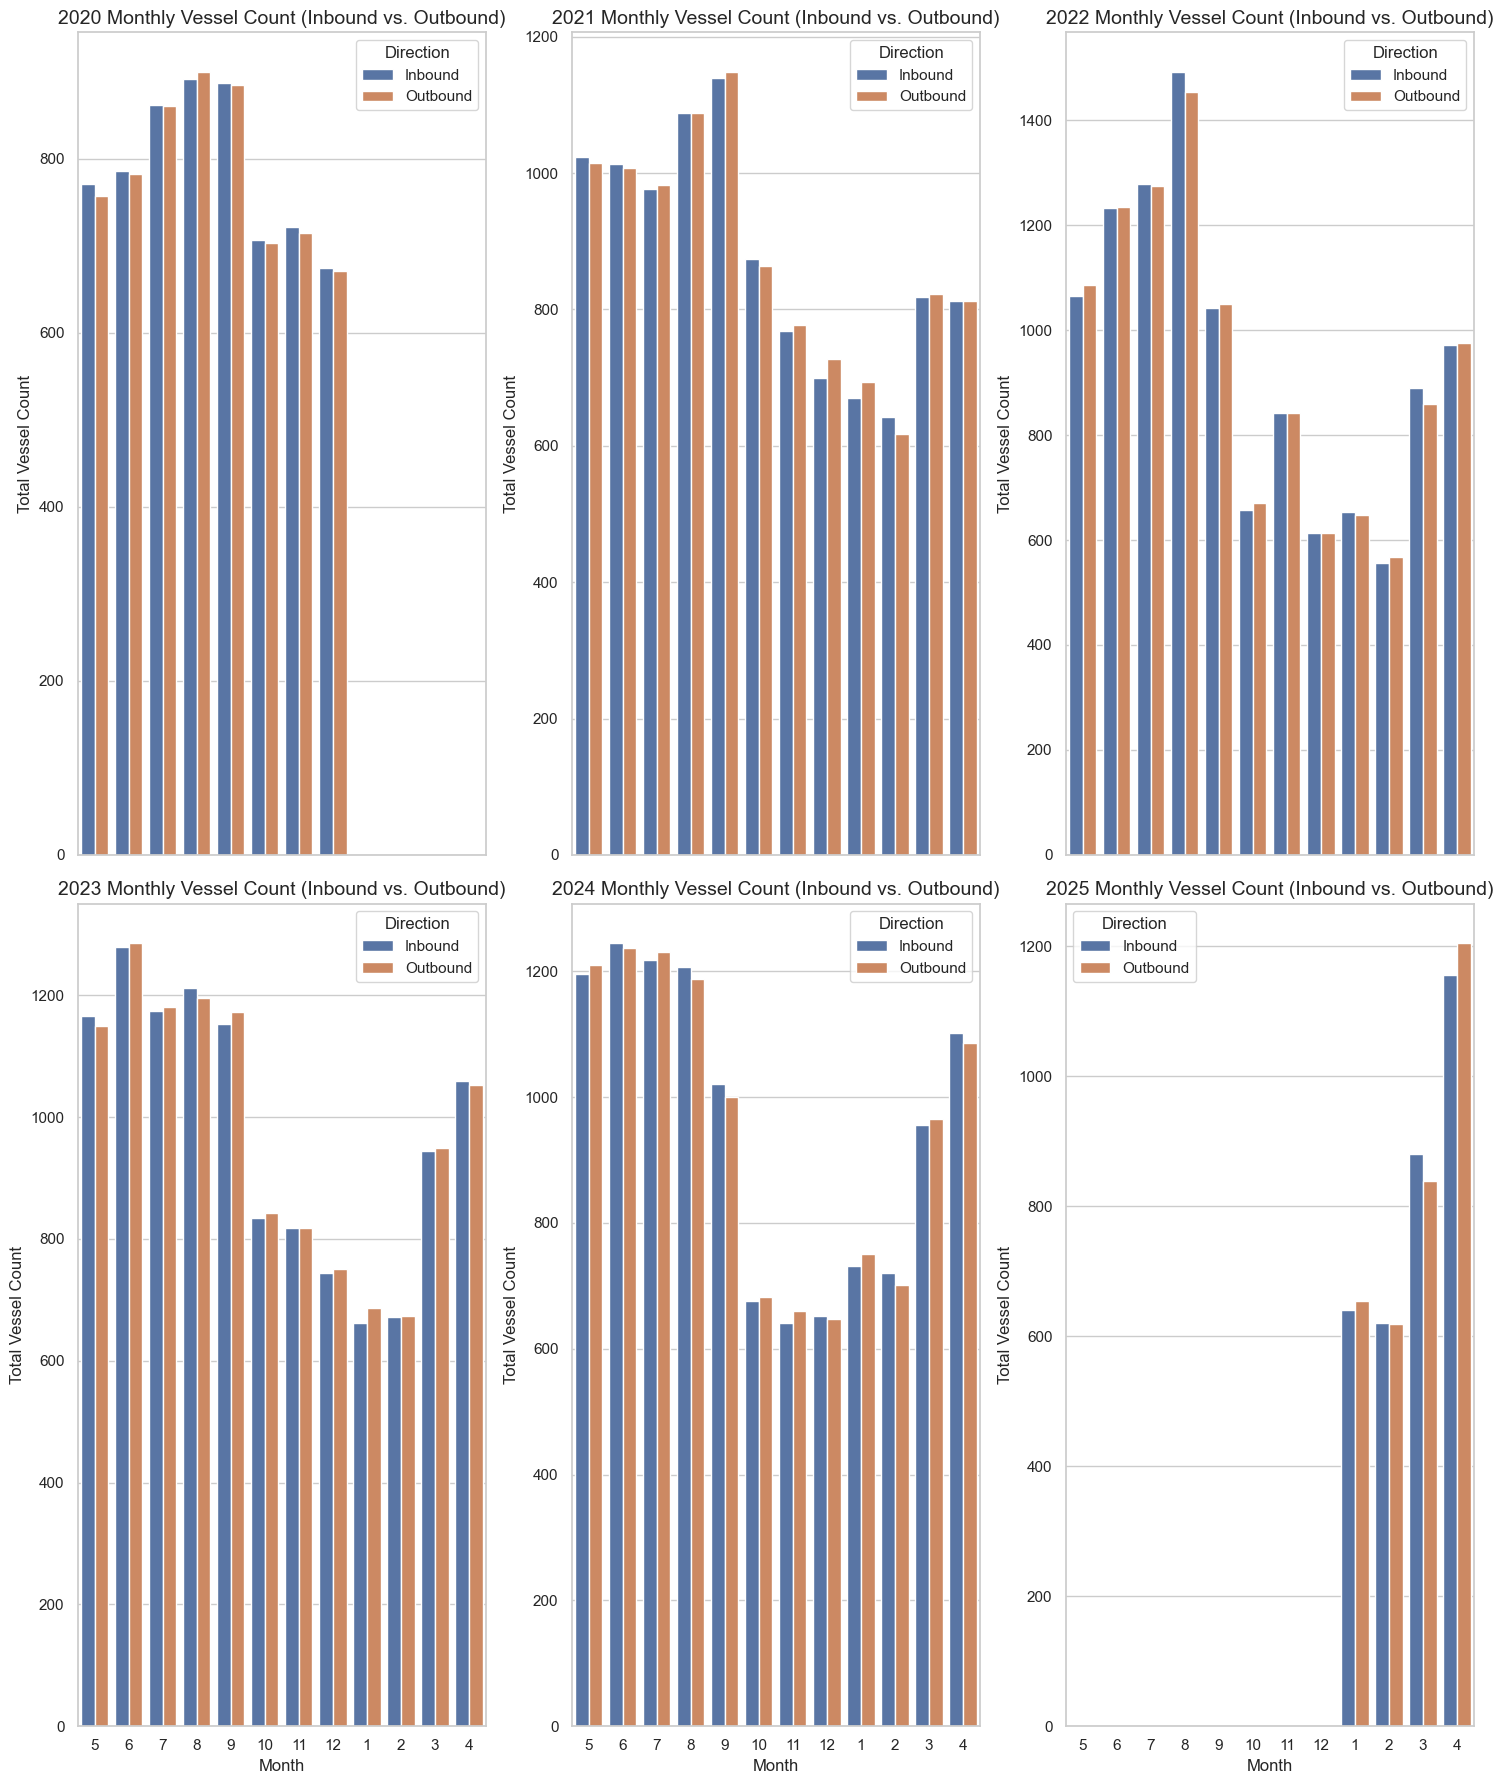

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# 設定英文字體，避免中文字缺字問題
matplotlib.rcParams['font.family'] = 'Arial'

# 解決負號顯示為方塊的問題
matplotlib.rcParams['axes.unicode_minus'] = False

# 確保時間欄位是 datetime 格式
df_final['年月'] = pd.to_datetime(df_final['年月'])

# 取出年份與月份
df_final['年份'] = df_final['年月'].dt.year
df_final['月份'] = df_final['年月'].dt.month

# 依 年、月、進出 分組統計艘次
df_grouped = df_final.groupby(['年份', '月份', '進出'])['艘次'].sum().reset_index()

# 設定繪圖風格
sns.set(style="whitegrid")

# 取出所有年份（會繪製一張圖 per 年）
unique_years = sorted(df_grouped['年份'].unique())
n_years = len(unique_years)

# 建立3x2子圖畫布，最多放6張圖
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 18), sharex=True)

# 將axes攤平成一維陣列好用zip搭配年份迴圈
axes = axes.flatten()

# 繪製每個年份的圖
for i, year in enumerate(unique_years):
    ax = axes[i]
    df_year = df_grouped[df_grouped['年份'] == year]
    sns.barplot(data=df_year, x='月份', y='艘次', hue='進出', ax=ax)
    ax.set_title(f"{year} Monthly Vessel Count (Inbound vs. Outbound)", fontsize=14)
    ax.set_ylabel("Total Vessel Count")
    ax.set_xlabel("Month")
    ax.legend(title="Direction")

# 若子圖數多於年份，剩下的子圖清空（不顯示）
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/var/folders/2y/0mtp5mr56s73ff2f7_z800qr0000gn/T/ipykernel_10809/3724648507.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top5, x='艘次', y='船舶種類', palette='viridis', ax=ax)
/var/folders/2y/0mtp5mr56s73ff2f7_z800qr0000gn/T/ipykernel_10809/3724648507.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top5, x='艘次', y='船舶種類', palette='viridis', ax=ax)
/var/folders/2y/0mtp5mr56s73ff2f7_z800qr0000gn/T/ipykernel_10809/3724648507.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top5, x='艘次', y='船舶種類', palette='vir

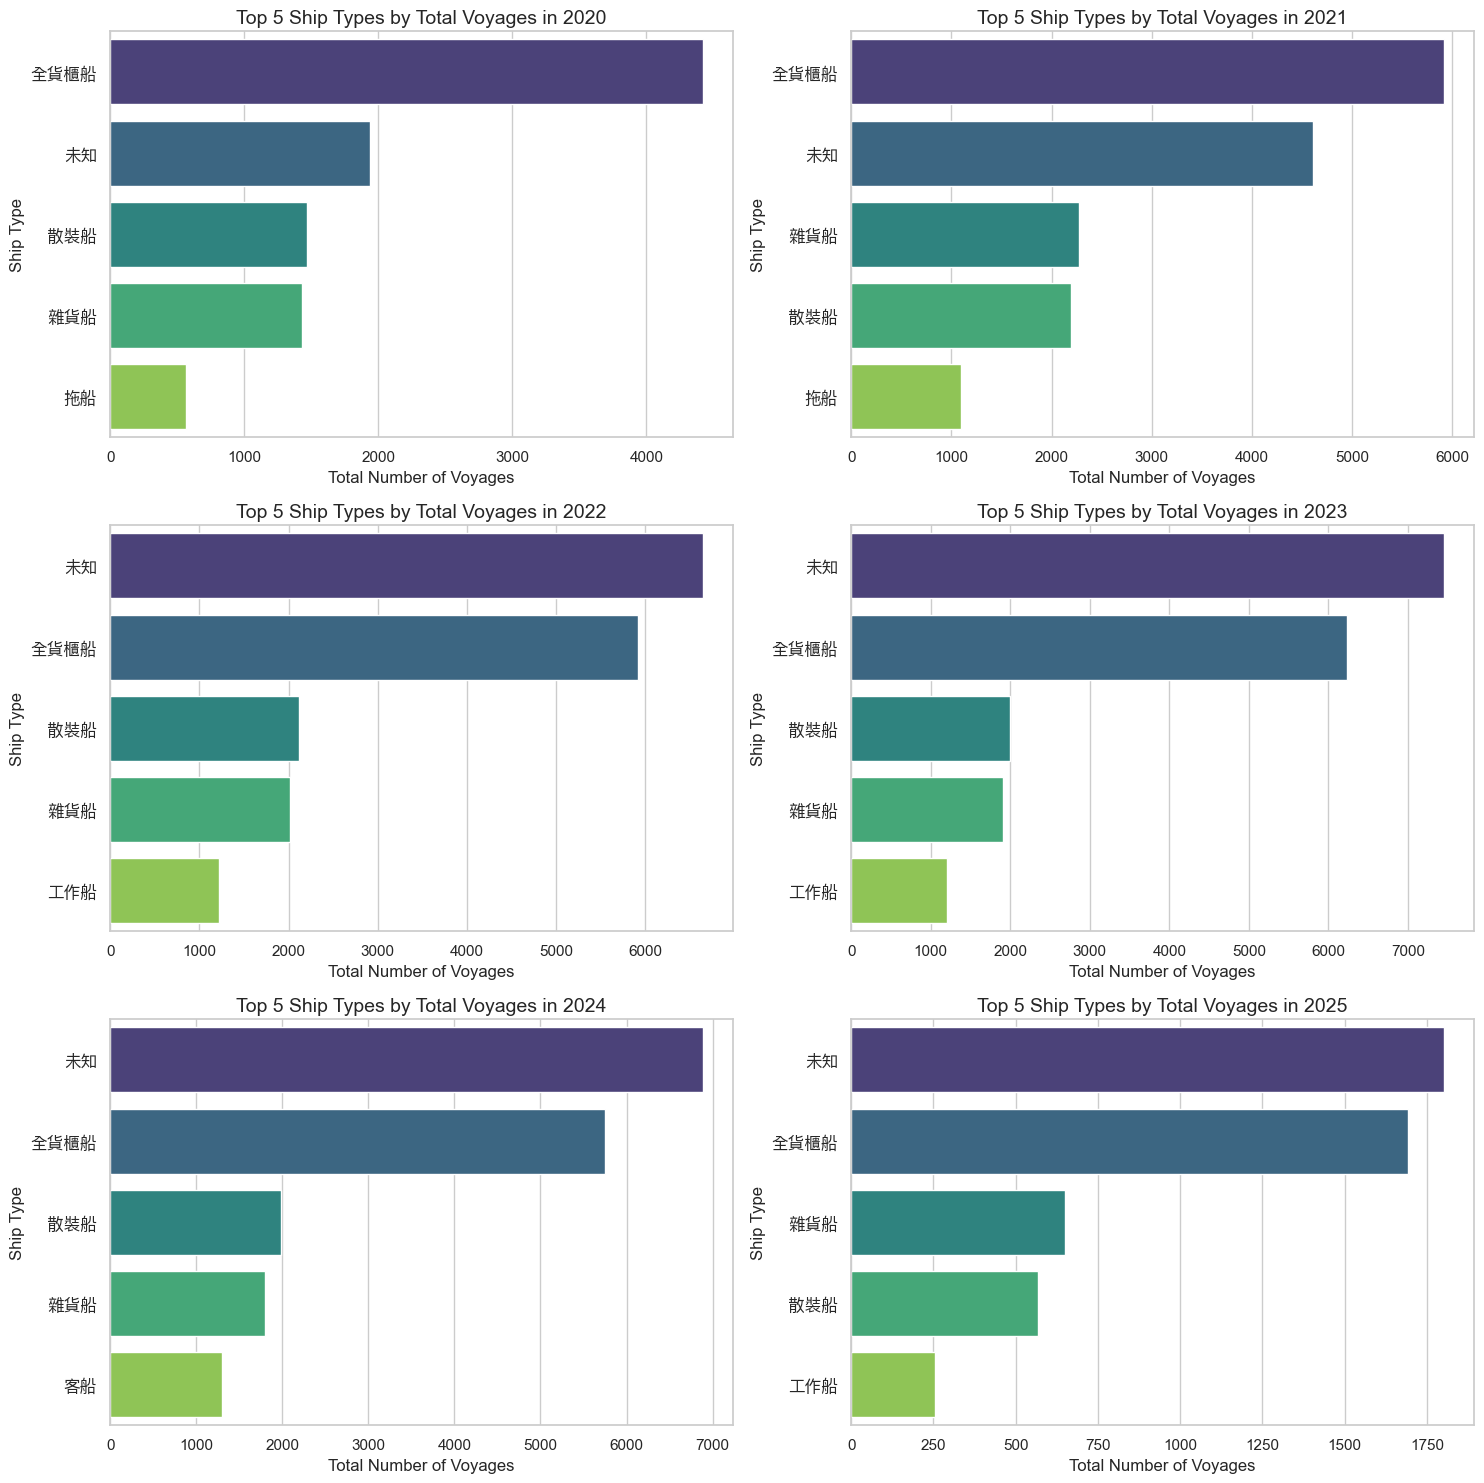

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 假設 df_final 已讀取並年月轉成 datetime
df_final['年月'] = pd.to_datetime(df_final['年月'])

# macOS 中文字體 PingFang
chinese_font_path = '/System/Library/Fonts/PingFang.ttc'
chinese_font = fm.FontProperties(fname=chinese_font_path)

years = range(2020, 2026)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    df_year = df_final[df_final['年月'].dt.year == year]
    df_sum = df_year.groupby('船舶種類')['艘次'].sum().reset_index()
    df_top5 = df_sum.sort_values('艘次', ascending=False).head(5)

    sns.barplot(data=df_top5, x='艘次', y='船舶種類', palette='viridis', ax=ax)

    ax.set_title(f'Top 5 Ship Types by Total Voyages in {year}', fontsize=14)
    ax.set_xlabel('Total Number of Voyages')
    ax.set_ylabel('Ship Type')

    # 設定 y 軸刻度中文字體
    for label in ax.get_yticklabels():
        label.set_fontproperties(chinese_font)

plt.tight_layout()
plt.show()

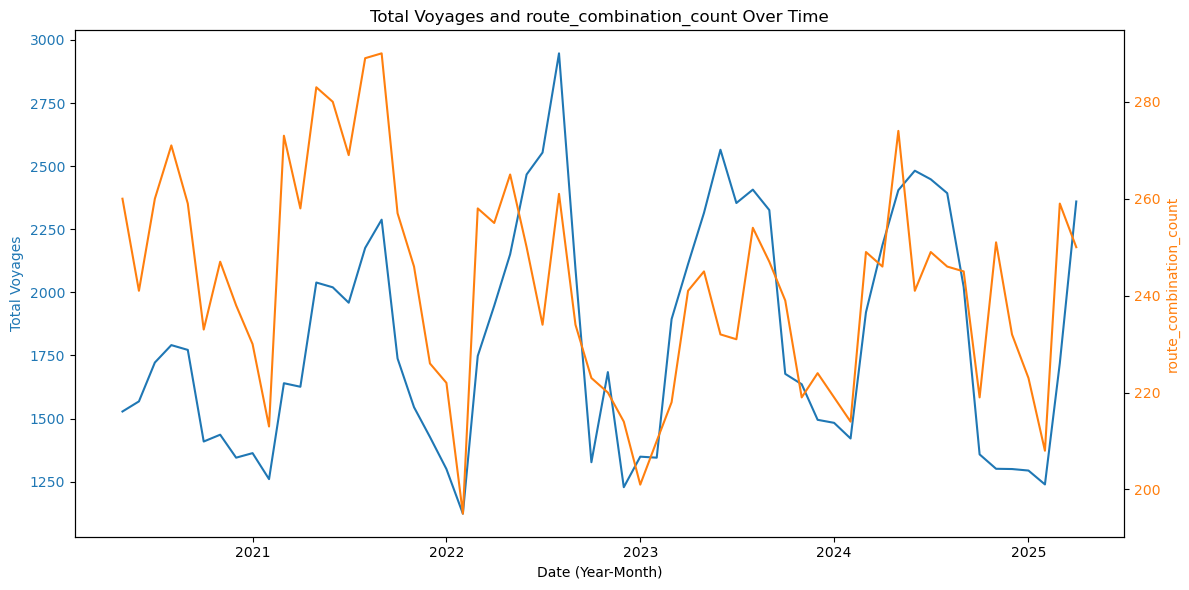

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設 df_final 已有且年月是 datetime
df_final['年月'] = pd.to_datetime(df_final['年月'])

# 合併進出艘次與港口數量，按年月+船舶種類群組
df_grouped = df_final.groupby(['年月', '船舶種類']).agg({
    '艘次': 'sum',            # Inbound+Outbound艘次合併
    '航線組合數': 'max'         # 航線組合數以最大值表示（或改成mean視需求）
}).reset_index()

# 按年月聚合，計算所有船舶種類的總艘次和港口數量
df_monthly = df_grouped.groupby('年月').agg({
    '艘次': 'sum',
    '航線組合數': 'sum'  # 航線組合數總和，或者你也可以取平均用 'mean'
}).reset_index()

# 繪圖
fig, ax1 = plt.subplots(figsize=(12,6))

color1 = 'tab:blue'
ax1.set_xlabel('Date (Year-Month)')
ax1.set_ylabel('Total Voyages', color=color1)
ax1.plot(df_monthly['年月'], df_monthly['艘次'], color=color1, label='Total Voyages')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # 建立共用x軸的第二個y軸
color2 = 'tab:orange'
ax2.set_ylabel('route_combination_count', color=color2)
ax2.plot(df_monthly['年月'], df_monthly['航線組合數'], color=color2, label='Total Number of Ports')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Total Voyages and route_combination_count Over Time')
fig.tight_layout()
plt.show()

進港筆數: 15366
出港筆數: 15277
來源港
高雄港(TWKHH)    8715
基隆港(TWKEL)    6187
TWOWP9        3634
TWOWP3        3042
臺北港(TWTPE)    2761
TWTXGOS       2292
TWOWP2        2260
TWOWPC        2184
臺中港(TWTXG)    1330
TWOWP8         871
Name: 艘次, dtype: int64
目的港
高雄港(TWKHH)    9953
TWOWP9        3653
TWOWP3        3032
TWTXGOS       2753
臺北港(TWTPE)    2352
TWOWP2        2291
TWOWPC        2189
基隆港(TWKEL)    1906
香港港(HKHKG)    1287
CNXAM         1098
Name: 艘次, dtype: int64


/var/folders/2y/0mtp5mr56s73ff2f7_z800qr0000gn/T/ipykernel_10809/1762493753.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=inbound_ports_freq.head(10).values, y=inbound_ports_freq.head(10).index, palette='Reds_r')
/var/folders/2y/0mtp5mr56s73ff2f7_z800qr0000gn/T/ipykernel_10809/1762493753.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outbound_ports_freq.head(10).values, y=outbound_ports_freq.head(10).index, palette='Blues_r')


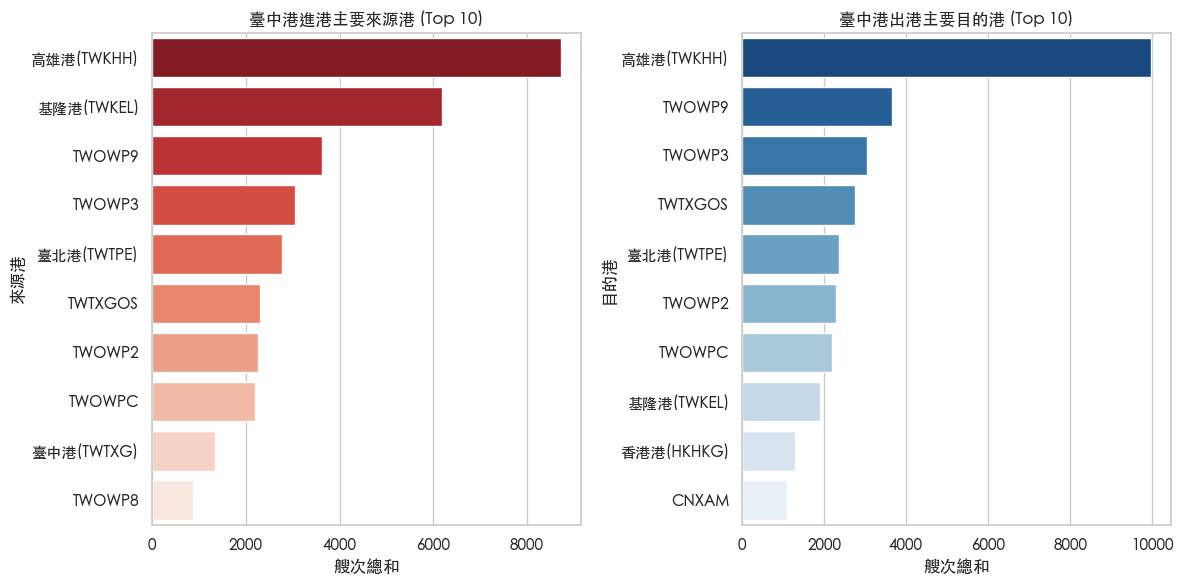

In [206]:
plt.rcParams['font.family'] = 'Heiti TC'  # 或 Heiti TC, Hiragino Sans GB, AppleGothic
plt.rcParams['axes.unicode_minus'] = False  # 確保負號顯示正確
# 進港資料（目的港為臺中港，目的港欄位實際為NA，不用篩）
df_inbound = df[df['進出'] == 'Inbound']

# 出港資料（來源港為臺中港，來源港欄位實際為NA，不用篩）
df_outbound = df[df['進出'] == 'Outbound']

# 計算進港主要來源港艘次總和
inbound_ports_freq = df_inbound.groupby('來源港')['艘次'].sum().sort_values(ascending=False)

# 計算出港主要目的港艘次總和
outbound_ports_freq = df_outbound.groupby('目的港')['艘次'].sum().sort_values(ascending=False)

# 印出筆數確認
print(f'進港筆數: {len(df_inbound)}')
print(f'出港筆數: {len(df_outbound)}')

print(inbound_ports_freq.head(10))
print(outbound_ports_freq.head(10))

# 畫圖
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=inbound_ports_freq.head(10).values, y=inbound_ports_freq.head(10).index, palette='Reds_r')
plt.title('臺中港進港主要來源港 (Top 10)')
plt.xlabel('艘次總和')
plt.ylabel('來源港')

plt.subplot(1, 2, 2)
sns.barplot(x=outbound_ports_freq.head(10).values, y=outbound_ports_freq.head(10).index, palette='Blues_r')
plt.title('臺中港出港主要目的港 (Top 10)')
plt.xlabel('艘次總和')
plt.ylabel('目的港')

plt.tight_layout()
plt.show()

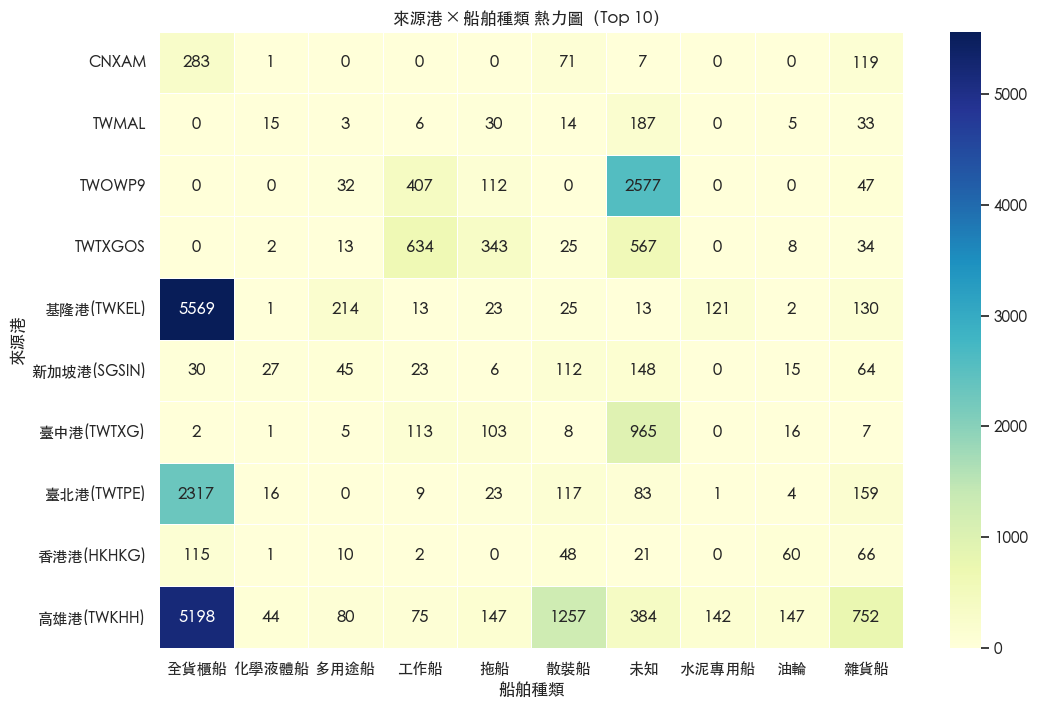

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
plt.rcParams['font.family'] = 'Heiti TC'  # 或 Heiti TC, Hiragino Sans GB, AppleGothic
plt.rcParams['axes.unicode_minus'] = False  # 確保負號顯示正確

df['來源港'] = df['來源港'].fillna('未知').str.strip()
df['船舶種類'] = df['船舶種類'].fillna('未知').str.strip()
# 取前 10 個最常見來源港 & 船舶種類
top_ports = df_inbound['來源港'].value_counts().head(10).index
top_ship_types = df_inbound['船舶種類'].value_counts().head(10).index

# 過濾資料
df_top = df_inbound[df_inbound['來源港'].isin(top_ports) & df_inbound['船舶種類'].isin(top_ship_types)]

# 建立交叉表
pivot_table = df_top.pivot_table(index='來源港', columns='船舶種類', values='艘次', aggfunc='sum', fill_value=0)

# 繪製
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5)
plt.title('來源港 × 船舶種類 熱力圖（Top 10）')
plt.xlabel('船舶種類')
plt.ylabel('來源港')
plt.show()

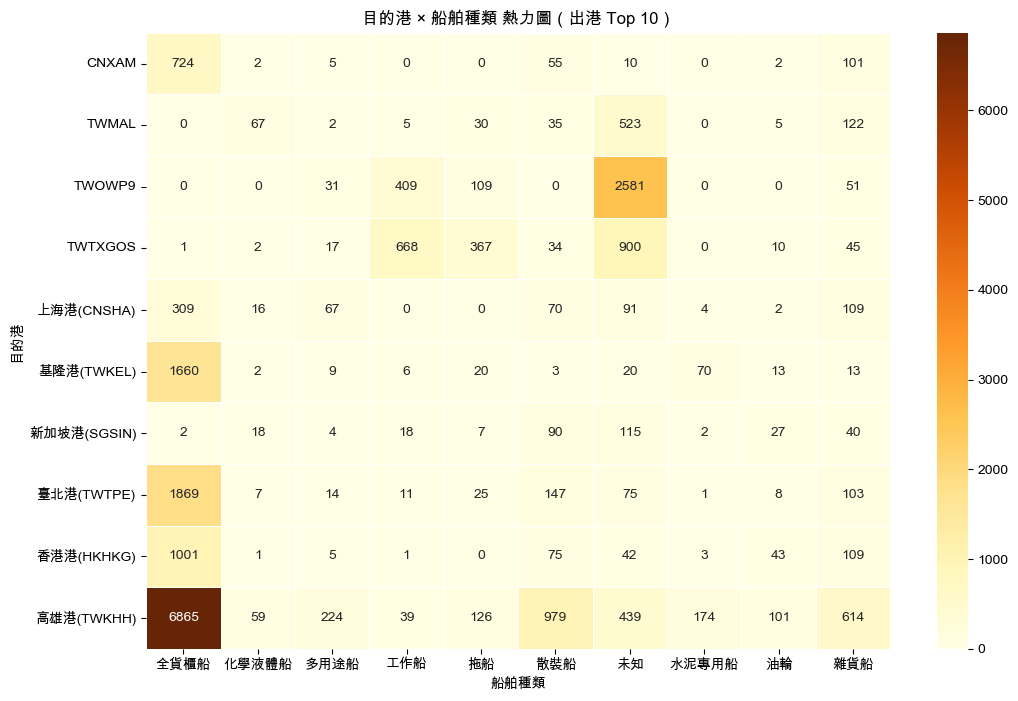

In [127]:
# 取出出港資料（不需要篩來源港）
df_outbound = df[df['進出'] == 'Outbound']

# 篩選 Top 10 目的港 和 Top 10 船舶種類
top_ports = df_outbound['目的港'].value_counts().head(10).index
top_ship_types = df_outbound['船舶種類'].value_counts().head(10).index

# 過濾資料
df_top = df_outbound[df_outbound['目的港'].isin(top_ports) & df_outbound['船舶種類'].isin(top_ship_types)]

# 建立交叉表
pivot_table = df_top.pivot_table(index='目的港', columns='船舶種類', values='艘次', aggfunc='sum', fill_value=0)

# 畫熱力圖
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlOrBr', annot=True, fmt='.0f', linewidths=0.5)
plt.title('目的港 × 船舶種類 熱力圖（出港 Top 10）')
plt.xlabel('船舶種類')
plt.ylabel('目的港')
plt.show()

/var/folders/2y/0mtp5mr56s73ff2f7_z800qr0000gn/T/ipykernel_10809/15251816.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['年份'] = pd.to_datetime(df_clean['年月'], errors='coerce').dt.year


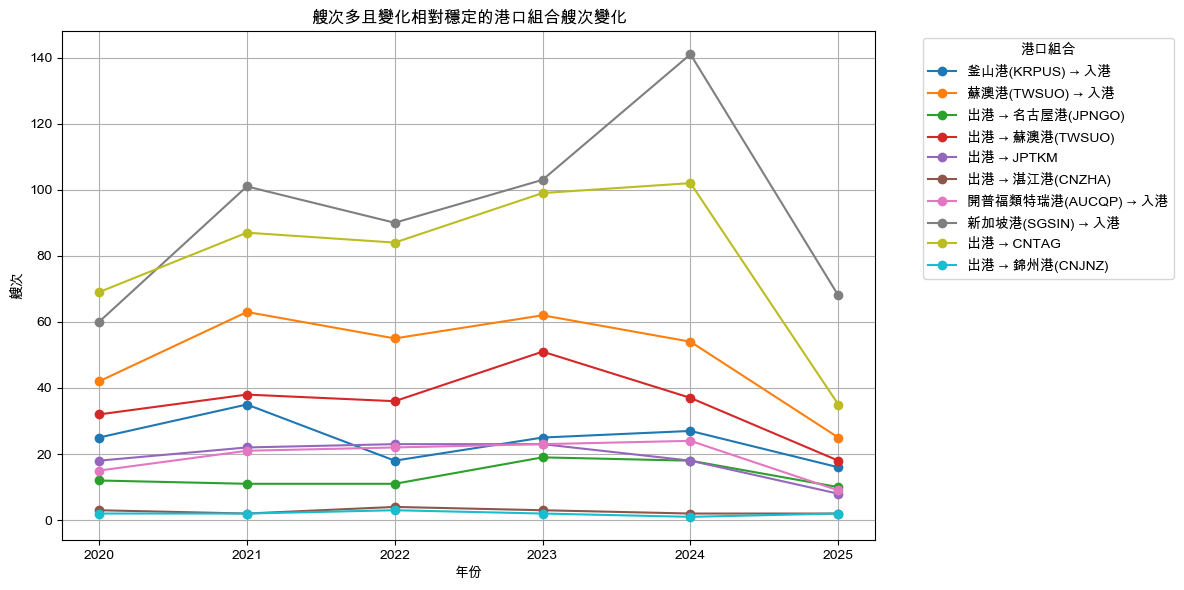

In [161]:
# 1. 剔除未知船舶種類
df_clean = df[df['船舶種類'] != '未知'].copy()

# 2. 建立年份欄位
df_clean['年份'] = pd.to_datetime(df_clean['年月'], errors='coerce').dt.year
df_clean = df_clean.dropna(subset=['年份'])

# 3. 建立港口組合欄位
def get_combo(row):
    if row['進出'] == 'Inbound':
        return row['來源港'] + ' → 入港'
    elif row['進出'] == 'Outbound':
        return '出港 → ' + row['目的港']
    else:
        return None

df_clean['港口組合'] = df_clean.apply(get_combo, axis=1)
df_clean = df_clean[df_clean['港口組合'].notna()]

# 4. 群組統計
yearly_combo = df_clean.groupby(['年份', '港口組合'])['艘次'].sum().reset_index()

# 5. 找出每年都有出現的組合
all_years = sorted(df_clean['年份'].unique())
year_count = yearly_combo.groupby('港口組合')['年份'].nunique()
stable_combos = year_count[year_count == len(all_years)].index

stable_df = yearly_combo[yearly_combo['港口組合'].isin(stable_combos)]

# 6. 轉成寬表
pivot_df = stable_df.pivot(index='年份', columns='港口組合', values='艘次')

# 7. 計算平均艘次和標準差
avg_艘次 = pivot_df.mean()
stable_variation = pivot_df.std()

# 計算穩定性指標（平均艘次除以標準差，避免除以0）
stability_score = avg_艘次 / (stable_variation + 1e-5)

# 按照穩定性指標排序，取前10名
top_stable_combos = stability_score.sort_values(ascending=False).head(10).index

# 8. 繪圖
plt.figure(figsize=(12,6))
for combo in top_stable_combos:
    plt.plot(pivot_df.index, pivot_df[combo], marker='o', label=combo)

plt.title('艘次多且變化相對穩定的港口組合艘次變化')
plt.xlabel('年份')
plt.ylabel('艘次')
plt.legend(title='港口組合', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()